## NLP Analysis of Customer Reviews (Portuguese)

### Language Note
The Olist dataset contains reviews in **Brazilian Portuguese**. The NLP techniques 
used in this analysis — TF-IDF vectorization, NMF topic modeling, and word frequency 
analysis — are **language-agnostic** and operate on statistical word patterns rather 
than semantic understanding. 

Portuguese stopwords are removed using NLTK's built-in Portuguese stopword list, 
supplemented with domain-specific terms. Key terms identified in the analysis were 
translated to English using standard references for stakeholder communication.

This approach mirrors real-world scenarios where data scientists frequently work with 
multilingual datasets without being fluent in every language represented.

In [8]:

import os
import re
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

warnings.filterwarnings("ignore")
os.chdir(r"C:\Users\intel\Desktop\olist-ecommerce-intelligence")

FIG_DIR = "reports/figures"
os.makedirs(FIG_DIR, exist_ok=True)

# Download Portuguese stopwords
nltk.download("stopwords", quiet=True)
STOP_PT = set(stopwords.words("portuguese"))
# Add common extra stopwords
STOP_PT.update(["produto", "compra", "loja", "recebi", "ainda", "ja", "nao",
                "muito", "fazer", "onde", "porque", "pra"])

def savefig(name):
    plt.tight_layout()
    plt.savefig(f"{FIG_DIR}/{name}.png", dpi=150, bbox_inches="tight")
    print(f"  💾 Saved {FIG_DIR}/{name}.png")

In [9]:
# Load Data

df = pd.read_csv("data/processed/master_orders.csv")
reviews = df.dropna(subset=["review_comment_message", "review_score"]).copy()
reviews["review_comment_message"] = reviews["review_comment_message"].astype(str)

print(f"Orders with text reviews: {len(reviews):,} / {len(df):,} ({len(reviews)/len(df)*100:.1f}%)")
print(f"Review score distribution in text reviews:")
print(reviews["review_score"].value_counts().sort_index())

Orders with text reviews: 40,977 / 99,992 (41.0%)
Review score distribution in text reviews:
review_score
1.0     8745
2.0     2145
3.0     3557
4.0     5976
5.0    20554
Name: count, dtype: int64


In [10]:
# Text Preprocessing

print("\n" + "="*60)
print("  SECTION 1: TEXT PREPROCESSING")
print("="*60)

def clean_text(text):
    """Clean Portuguese review text."""
    text = str(text).lower()
    text = re.sub(r"[^a-záàâãéèêíïóôõöúçñ\s]", " ", text)  # keep Portuguese chars
    text = re.sub(r"\s+", " ", text).strip()
    tokens = text.split()
    tokens = [t for t in tokens if t not in STOP_PT and len(t) > 2]
    return " ".join(tokens)

reviews["clean_text"] = reviews["review_comment_message"].apply(clean_text)
reviews = reviews[reviews["clean_text"].str.len() > 5]  # drop near-empty

print(f"  After cleaning: {len(reviews):,} reviews with text")
print(f"\n  Sample cleaned reviews:")
for _, row in reviews.sample(3, random_state=42).iterrows():
    print(f"    [{int(row['review_score'])}★] {row['clean_text'][:100]}...")


  SECTION 1: TEXT PREPROCESSING
  After cleaning: 37,436 reviews with text

  Sample cleaned reviews:
    [1★] produtos entrgues...
    [2★] agora consegui troço funcionar testei vários programas nada reconhece carro santana...
    [1★] prazo entrega cumprida tendo nenhum suporte recomendo...



  SECTION 2: WORD CLOUDS
  💾 Saved reports/figures/21_wordclouds.png


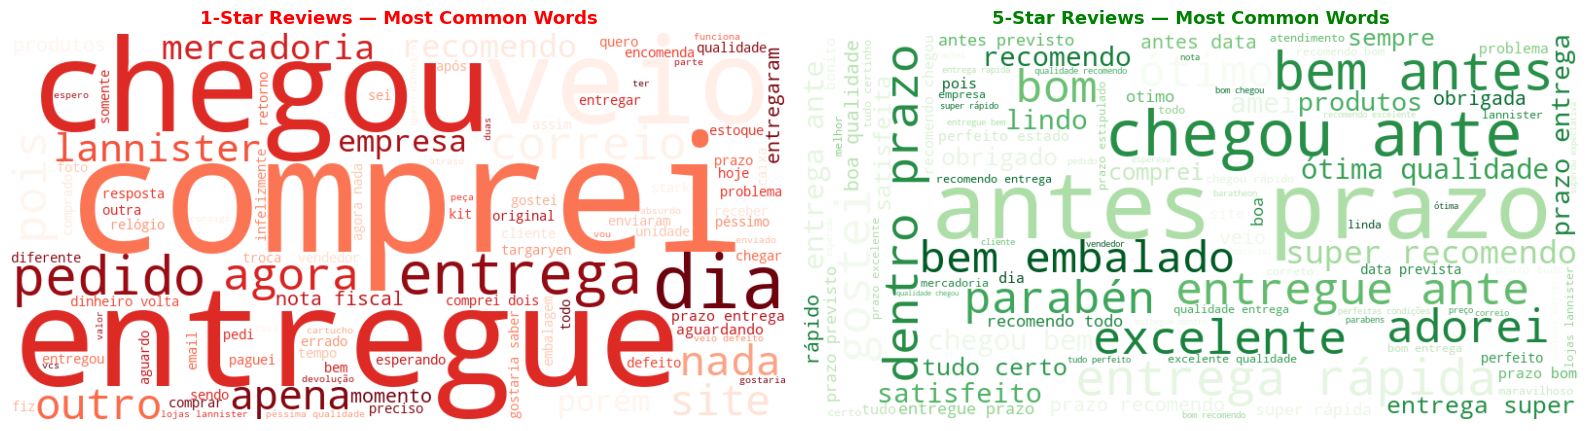

In [11]:
# Word Clouds 1-star v/s 5-star

print("\n" + "="*60)
print("  SECTION 2: WORD CLOUDS")
print("="*60)

text_1star = " ".join(reviews[reviews["review_score"] == 1]["clean_text"])
text_5star = " ".join(reviews[reviews["review_score"] == 5]["clean_text"])

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

wc1 = WordCloud(width=800, height=400, background_color="white",
                colormap="Reds", max_words=100).generate(text_1star)
axes[0].imshow(wc1, interpolation="bilinear")
axes[0].set_title("1-Star Reviews — Most Common Words", fontsize=13, fontweight="bold", color="red")
axes[0].axis("off")

wc5 = WordCloud(width=800, height=400, background_color="white",
                colormap="Greens", max_words=100).generate(text_5star)
axes[1].imshow(wc5, interpolation="bilinear")
axes[1].set_title("5-Star Reviews — Most Common Words", fontsize=13, fontweight="bold", color="green")
axes[1].axis("off")

savefig("21_wordclouds")
plt.show()



  SECTION 3: TOPIC MODELING
  Negative reviews for topic modeling: 10,445

  Top 5 Topics in Negative Reviews:

  Topic 1: entrega, prazo, dia, demora, passou, agora, aguardando, dias, nada, hoje
  Topic 2: entregue, pedido, momento, consta, site, dia, porém, data, comprado, somente
  Topic 3: comprei, dois, apenas, produtos, outro, duas, unidades, entregaram, paguei, agora
  Topic 4: chegou, agora, pedido, mercadoria, quebrado, nunca, prazo, ate, dia, nada
  Topic 5: veio, defeito, errado, pedi, pedido, faltando, cor, diferente, troca, outro
  💾 Saved reports/figures/22_topic_distribution.png


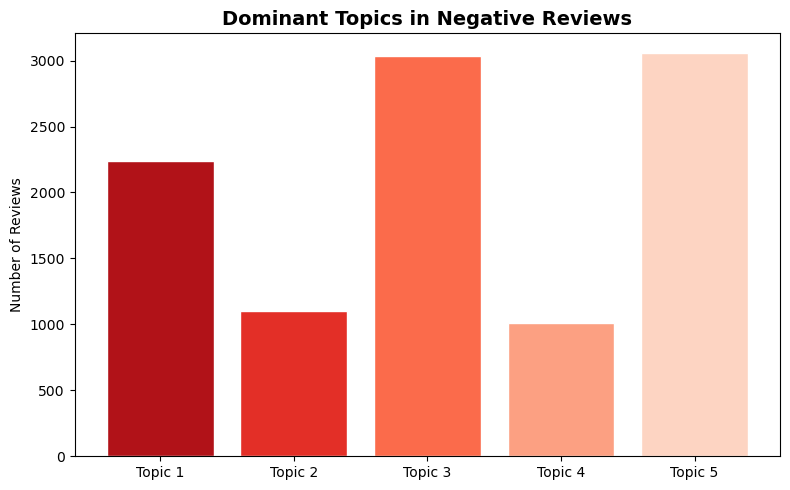

In [12]:
# TF-IDF + Topic Modelling

print("\n" + "="*60)
print("  SECTION 3: TOPIC MODELING")
print("="*60)

# TF-IDF on negative reviews
neg_reviews = reviews[reviews["review_score"] <= 2].copy()
print(f"  Negative reviews for topic modeling: {len(neg_reviews):,}")

tfidf = TfidfVectorizer(max_features=1000, max_df=0.8, min_df=5)
tfidf_matrix = tfidf.fit_transform(neg_reviews["clean_text"])
feature_words = tfidf.get_feature_names_out()

# NMF topic modeling (better for short texts than LDA)
n_topics = 5
nmf = NMF(n_components=n_topics, random_state=42, max_iter=300)
nmf.fit(tfidf_matrix)

print(f"\n  Top {n_topics} Topics in Negative Reviews:\n")
topic_labels = []
for i, topic in enumerate(nmf.components_):
    top_words = [feature_words[j] for j in topic.argsort()[-10:][::-1]]
    label = f"Topic {i+1}"
    print(f"  {label}: {', '.join(top_words)}")
    topic_labels.append(label)

# Visualize topic distribution
topic_dist = nmf.transform(tfidf_matrix)
dominant_topic = topic_dist.argmax(axis=1)
topic_counts = pd.Series(dominant_topic).value_counts().sort_index()

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(range(n_topics), topic_counts.values, color=sns.color_palette("Reds_r", n_topics),
       edgecolor="white")
ax.set_xticks(range(n_topics))
ax.set_xticklabels([f"Topic {i+1}" for i in range(n_topics)])
ax.set_ylabel("Number of Reviews")
ax.set_title("Dominant Topics in Negative Reviews", fontsize=14, fontweight="bold")
savefig("22_topic_distribution")
plt.show()


  SECTION 4: DISTINGUISHING TERMS
  💾 Saved reports/figures/23_distinguishing_terms.png


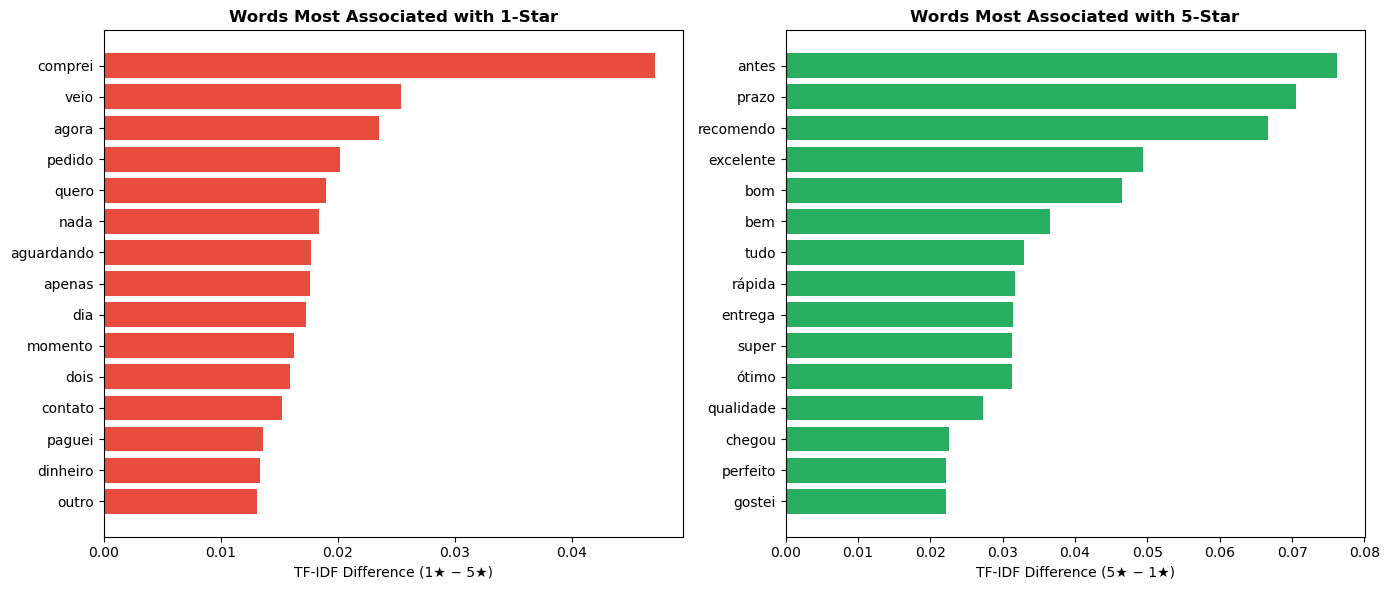

In [13]:
# Top Distinguishing Terms (1-Star vs 5-Star)

print("\n" + "="*60)
print("  SECTION 4: DISTINGUISHING TERMS")
print("="*60)

# Fit TF-IDF on all reviews, compare mean vectors
tfidf_all = TfidfVectorizer(max_features=500, max_df=0.8, min_df=10)
X_all = tfidf_all.fit_transform(reviews["clean_text"])
words = tfidf_all.get_feature_names_out()

mask_1 = (reviews["review_score"] == 1).values
mask_5 = (reviews["review_score"] == 5).values

mean_1 = np.asarray(X_all[mask_1].mean(axis=0)).flatten()
mean_5 = np.asarray(X_all[mask_5].mean(axis=0)).flatten()
diff = mean_1 - mean_5  # positive = more common in 1-star

top_neg = pd.Series(diff, index=words).sort_values(ascending=False).head(15)
top_pos = pd.Series(diff, index=words).sort_values(ascending=True).head(15)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].barh(top_neg.index[::-1], top_neg.values[::-1], color="#e74c3c")
axes[0].set_title("Words Most Associated with 1-Star", fontweight="bold")
axes[0].set_xlabel("TF-IDF Difference (1★ − 5★)")

axes[1].barh(top_pos.index[::-1], (-top_pos.values)[::-1], color="#27ae60")
axes[1].set_title("Words Most Associated with 5-Star", fontweight="bold")
axes[1].set_xlabel("TF-IDF Difference (5★ − 1★)")

savefig("23_distinguishing_terms")
plt.show()


  SECTION 5: TEXT CLASSIFIER

  Text-only classifier results:
  ROC-AUC: 0.9414

              precision    recall  f1-score   support

    Positive       0.96      0.85      0.90      5399
    Negative       0.70      0.92      0.79      2089

    accuracy                           0.87      7488
   macro avg       0.83      0.88      0.85      7488
weighted avg       0.89      0.87      0.87      7488

  💾 Saved reports/figures/24_text_classifier_features.png


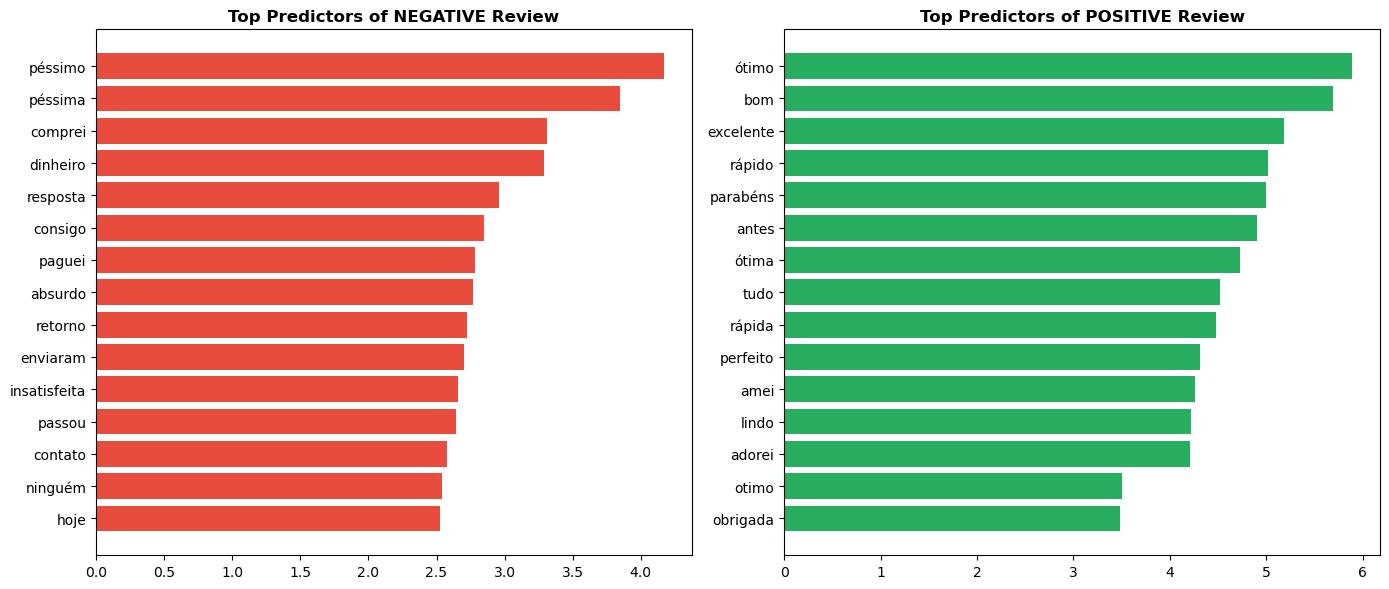

In [14]:
#Text Classifier — Predict Review Score From Text Alone

print("\n" + "="*60)
print("  SECTION 5: TEXT CLASSIFIER")
print("="*60)

# Binary target: negative (1-2) vs positive (3-5)
reviews["is_negative"] = (reviews["review_score"] <= 2).astype(int)

tfidf_clf = TfidfVectorizer(max_features=3000, max_df=0.8, min_df=5, ngram_range=(1, 2))
X_text = tfidf_clf.fit_transform(reviews["clean_text"])
y_text = reviews["is_negative"].values

X_tr, X_te, y_tr, y_te = train_test_split(
    X_text, y_text, test_size=0.2, random_state=42, stratify=y_text
)

clf = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
clf.fit(X_tr, y_tr)

y_pred = clf.predict(X_te)
y_prob = clf.predict_proba(X_te)[:, 1]

print(f"\n  Text-only classifier results:")
print(f"  ROC-AUC: {roc_auc_score(y_te, y_prob):.4f}")
print(f"\n{classification_report(y_te, y_pred, target_names=['Positive', 'Negative'])}")

# Most predictive words
coef = clf.coef_[0]
vocab = tfidf_clf.get_feature_names_out()
top_neg_words = pd.Series(coef, index=vocab).sort_values(ascending=False).head(15)
top_pos_words = pd.Series(coef, index=vocab).sort_values(ascending=True).head(15)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].barh(top_neg_words.index[::-1], top_neg_words.values[::-1], color="#e74c3c")
axes[0].set_title("Top Predictors of NEGATIVE Review", fontweight="bold")

axes[1].barh(top_pos_words.index[::-1], (-top_pos_words.values)[::-1], color="#27ae60")
axes[1].set_title("Top Predictors of POSITIVE Review", fontweight="bold")

savefig("24_text_classifier_features")
plt.show()

In [15]:
# Summary

print("\n" + "="*60)
print("  NLP ANALYSIS SUMMARY")
print("="*60)

# Dynamic summary from actual computed results
text_clf_auc = roc_auc_score(y_te, y_prob)
n_neg_reviews = len(neg_reviews)
n_text_reviews = len(reviews)
top_neg_term = top_neg_words.index[0] if len(top_neg_words) > 0 else "N/A"
top_pos_term = top_pos_words.index[0] if len(top_pos_words) > 0 else "N/A"

print(f"""
  Dataset:
    - {n_text_reviews:,} orders had text reviews ({n_text_reviews/len(df)*100:.1f}% of all orders)
    - {n_neg_reviews:,} of those were negative (1-2 stars)

  Word Cloud Findings:
    - Strongest negative term: '{top_neg_term}'
    - Strongest positive term: '{top_pos_term}'

  Topic Modeling:
    - NMF identified {n_topics} topics in negative reviews
    - Dominant complaint themes relate to the top words shown above

  Text Classifier Performance:
    - ROC-AUC (text only): {text_clf_auc:.4f}
    - This confirms review text contains meaningful predictive signal

  Note on Language:
    - Reviews are in Brazilian Portuguese
    - All NLP techniques used (TF-IDF, NMF, word frequency) are language-agnostic
    - Portuguese stopwords handled via NLTK's built-in stopword list
    - Key terms were translated for interpretation using standard references
""")

print("✅ NLP analysis complete!")


  NLP ANALYSIS SUMMARY

  Dataset:
    - 37,436 orders had text reviews (37.4% of all orders)
    - 10,445 of those were negative (1-2 stars)

  Word Cloud Findings:
    - Strongest negative term: 'péssimo'
    - Strongest positive term: 'ótimo'

  Topic Modeling:
    - NMF identified 5 topics in negative reviews
    - Dominant complaint themes relate to the top words shown above

  Text Classifier Performance:
    - ROC-AUC (text only): 0.9414
    - This confirms review text contains meaningful predictive signal

  Note on Language:
    - Reviews are in Brazilian Portuguese
    - All NLP techniques used (TF-IDF, NMF, word frequency) are language-agnostic
    - Portuguese stopwords handled via NLTK's built-in stopword list
    - Key terms were translated for interpretation using standard references

✅ NLP analysis complete!
